# Create Global Mask NetCDF File from Regional

## Import dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

## Read in regional mask and print file info

In [2]:
orig_file = '/n/home08/elundgren/ExtData/HEMCO/MASKS/v2014-07/AF_LANDMASK.geos.05x0666.nc'
ds_regional = xr.open_dataset(orig_file)
ds_regional

<xarray.Dataset>
Dimensions:   (lat: 155, lon: 112, time: 1)
Coordinates:
  * lon       (lon) float32 -20.0 -19.3333 -18.6667 -18.0 -17.3333 -16.6667 ...
  * lat       (lat) float32 -37.5 -37.0 -36.5 -36.0 -35.5 -35.0 -34.5 -34.0 ...
  * time      (time) datetime64[ns] 1985-01-01
Data variables:
    LANDMASK  (lat, lon) float32 ...

In [3]:
for k in ds_regional.dims:
   print('{} attributes: {}'.format(k, ds_regional[k].attrs))

lat attributes: OrderedDict([('standard_name', 'latitude'), ('long_name', 'Latitude'), ('units', 'degrees_north'), ('axis', 'Y')])
lon attributes: OrderedDict([('standard_name', 'longitude'), ('long_name', 'Longitude'), ('units', 'degrees_east'), ('axis', 'X')])
time attributes: OrderedDict([('standard_name', 'time')])


NOTE: There are several missing attributes when I compare these lists to a header ncdump of the file. It seems xarray does not show all imported attributes. Therefore I will manually add attributes based on what I see in the file rather than what I see here. 

## Plot Regional Mask

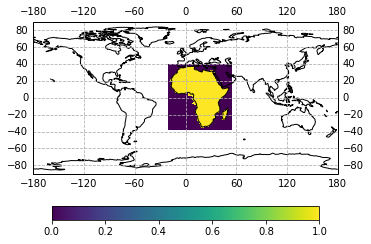

In [4]:
ax = plt.axes(projection=crs.PlateCarree())
ax.coastlines()  # overlay continents
ax.gridlines(draw_labels=True, linestyle='--')
im = ax.pcolormesh(ds_regional['lon'], ds_regional['lat'], ds_regional['LANDMASK'])
ax.set_global()
plt.colorbar(im, orientation='horizontal', shrink=0.8);


## Define function to make global lat/lon half-polar grid

In [5]:
def make_grid_LL(llres):
    [dlat,dlon] = list(map(float, llres.split('x')))
    lon_b = np.linspace(-180 - dlon/2, 180 - dlon/2, int(360/dlon) + 1, endpoint=True)
    lat_b = np.linspace(-90 - dlat/2, 90 + dlat/2, int(180/dlat) + 2, endpoint=True).clip(-90,90)
    lat = (lat_b[1:] + lat_b[:-1]) / 2
    lon = (lon_b[1:] + lon_b[:-1]) / 2
    llgrid = {'lat': lat, 'lon': lon}
    return llgrid

## Make a global grid at the same resolution as the regional mask

In [6]:
grid_res = '0.5x0.6666666666'
global_grid = make_grid_LL(grid_res)

## Sanity check the grids and find regional index bounds in global array

In [7]:
# First, print basic information about the global grid
print('Grid resolution: {}'.format(grid_res))
print('Longitude [min, max, size]: {}'.format([global_grid['lon'].min(), 
                                                 global_grid['lon'].max(), 
                                                 global_grid['lon'].size]))
print('Latitude [min, max, size]: {}'.format([global_grid['lat'].min(), 
                                                 global_grid['lat'].max(), 
                                                 global_grid['lat'].size]))

Grid resolution: 0.5x0.6666666666
Longitude [min, max, size]: [-179.99999999996669, 179.33333333336665, 540]
Latitude [min, max, size]: [-89.875, 89.875, 361]


In [8]:
# Show info about longitudes in the original regional file
print('Min lon regional: {}'.format(ds_regional['lon'].values.min()))
print('Max lon regional: {}'.format(ds_regional['lon'].values.max()))
print('Number longitudes: {}'.format(np.size(ds_regional['lon'].values)))

Min lon regional: -19.999996185302734
Max lon regional: 54.00000762939453
Number longitudes: 112


In [9]:
# Play with global longitude indexing to see if you can get a match
iminlon=240
imaxlon=351
print('Corresponding lon in global grid at index {}: {}'.format(iminlon,global_grid['lon'][iminlon]))
print('Corresponding lon in global grid at index {}: {}'.format(imaxlon,global_grid['lon'][imaxlon]))
print('Number longitudes bounded: {}'.format(np.size(global_grid['lon'][iminlon:imaxlon+1])))

Corresponding lon in global grid at index 240: -19.999999999966676
Corresponding lon in global grid at index 351: 54.000000000033324
Number longitudes bounded: 112


In [10]:
# Show info about latitudes in the original regional file
print('Min lat regional: {}'.format(ds_regional['lat'].values.min()))
print('Max lat regional: {}'.format(ds_regional['lat'].values.max()))
print('Number latitudes: {}'.format(np.size(ds_regional['lat'].values)))

Min lat regional: -37.5
Max lat regional: 39.5
Number latitudes: 155


In [11]:
# Play with global latitude indexing to see if you can get a match
iminlat=105
imaxlat=259
print('Corresponding lat in global grid at index {}: {}'.format(iminlat,global_grid['lat'][iminlat]))
print('Corresponding lat in global grid at index {}: {}'.format(imaxlat,global_grid['lat'][imaxlat]))
print('Number latitudes bounded: {}'.format(np.size(global_grid['lat'][iminlat:imaxlat+1])))

Corresponding lat in global grid at index 105: -37.5
Corresponding lat in global grid at index 259: 39.5
Number latitudes bounded: 155


## Define numpy arrays for the global grid using the data types in the regional file
NOTE: The original file landmask does not have a time dimension but I am adding the time dimension for the global file. 

In [12]:
# dimension ordering MUST be (time,lat,lon) for successful read in GEOS-Chem
mask = np.zeros([1,np.size(global_grid['lat']),np.size(global_grid['lon'])], dtype='single')
timearr = np.zeros([1], dtype='double')
latarr = np.array(global_grid['lat'], dtype='single')
lonarr = np.array(global_grid['lon'], dtype='single')


## Create Dataset for mask with global bounds and set attributes

In [13]:
ds_global = xr.Dataset({'LANDMASK': (['time','lat','lon'], mask)},
                        coords={'time':timearr,
                                'lat':latarr,
                                'lon':lonarr,  
                                })
ds_global['LANDMASK'].isel(time=0).data[iminlat:imaxlat+1,iminlon:imaxlon+1] = ds_regional['LANDMASK'].values[:,:]

ds_global['LANDMASK'].attrs = {
    'long_name': 'Africa domain mask',
    'units': 'unitless'}
ds_global['lon'].attrs = {
    'standard_name': 'longitude',
    'long_name': 'Longitude',
    'units': 'degrees_east',
    'axis': 'X'}
ds_global['lat'].attrs = {
    'standard_name': 'latitude',
    'long_name': 'Latitude',
    'units': 'degrees_north',
    'axis': 'Y'}
ds_global['time'].attrs = {
    'standard_name': 'time',
    'units': 'hours since 1985-01-01 00:00:00',
    'calendar': 'standard'}

ds_global

<xarray.Dataset>
Dimensions:   (lat: 361, lon: 540, time: 1)
Coordinates:
  * time      (time) float64 0.0
  * lat       (lat) float32 -89.875 -89.5 -89.0 -88.5 -88.0 -87.5 -87.0 ...
  * lon       (lon) float32 -180.0 -179.333 -178.667 -178.0 -177.333 ...
Data variables:
    LANDMASK  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

## Plot global mask

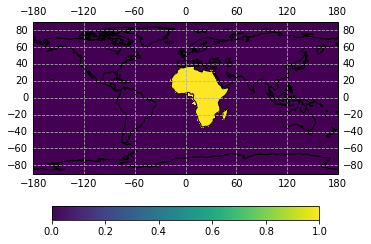

In [14]:
# Must first subset the time dimension to plot 2D not 3D
ds_global_t0 = ds_global.isel(time=0)

# Plot
ax = plt.axes(projection=crs.PlateCarree())
ax.coastlines()  # overlay continents
ax.gridlines(draw_labels=True, linestyle='--')
im = ax.pcolormesh(ds_global_t0['lon'], ds_global_t0['lat'], ds_global_t0['LANDMASK'].data)
ax.set_global()
plt.colorbar(im, orientation='horizontal', shrink=0.8);

## Save global mask to file

In [15]:
# Remove _FillValue attribute which is automatically placed into the file by xarray
# Doing this using the method below requires xarray v0.10.1 or higher due to this bug:
# https://github.com/pydata/xarray/issues/1865
ds_global.to_netcdf('/n/home08/elundgren/AF_LANDMASK.geos.05x0666.global.nc',
                    'w', format='NETCDF4',
                    encoding={'lat': {'_FillValue': None}, 
                              'lon': {'_FillValue': None}, 
                              'time': {'_FillValue': None},
                              'LANDMASK': {'_FillValue': None}})